In this notebook we explain how do we implement the Displaced Diffusion model, here are the steps

1. Retrieve market implied volatility
2. Find sigma and beta so that price difference (midprice - dd) is minimized
3. Use sigma and beta from #2 to calculate dd pricing
4. Retrieve impl vol for dd pricing results
5. Plot implied vols for market and DD

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import least_squares

In [2]:
#disp diffusion
def displaced_diffusion_call(F,K,r,sigma,T,beta):
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + (( 1 - beta ) / beta) * F
    d1 = (np.log(F_b / K_b) + (sigma_b ** 2/2) * T) / (sigma_b * np.sqrt(T))
    d2 = d1 - sigma_b * np.sqrt(T)
    return np.exp(-r * T) * (F_b * norm.cdf(d1) - K_b * norm.cdf(d2))


def displaced_diffusion_put(F,K,r,sigma,T,beta):
    F_b = F / beta
    sigma_b = sigma * beta
    K_b = K + ((1-beta)/beta) * F
    d1 = (np.log(F_b/K_b)+(sigma_b ** 2/2) * T) / (sigma_b * np.sqrt(T))
    d2 = d1 - sigma_b * np.sqrt(T)
    return np.exp(-r * T) * (K_b * norm.cdf(-d2) - F_b * norm.cdf(-d1))

In [3]:
#implied volatility reporting
def implied_volatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            #print('call impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_call(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            #print('put impl')
            impliedVol = brentq(lambda x: price -
                                black_scholes_put(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception as e:
        #print(e)
        impliedVol = np.nan

    return impliedVol

def black_scholes_call(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_put(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [4]:
#Read SPX data
filename = 'SPY_options'
df = pd.read_csv(f'{filename}.csv')
df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
df['strike'] = df['strike_price']*0.001
df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['exdate'] = pd.to_datetime(df['exdate'], format='%Y%m%d')
df['days_to_expiry'] = (df['exdate'] - df['date']).dt.days
df['years_to_expiry'] = df['days_to_expiry']/365

#setup rates calculator
rates_df = pd.read_csv('zero_rates_20201201.csv')
rate_interpolate = interp1d(rates_df['days'], rates_df['rate'])
df['rates'] = rate_interpolate(df['days_to_expiry']) / 100.0 #make it in fractions so i dont forget
try:
    if filename.lower() == 'spy_options':
        S = 366.02
    elif filename.lower() == 'spx_options':
        S = 3662.45
    else:
        raise NameError('unknown input file')
except Exception as e:
    print(e)

df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,mid,strike,payoff,days_to_expiry,years_to_expiry,rates
0,2020-12-01,2020-12-18,C,25000,340.74,341.20,A,340.970,25.0,call,17,0.046575,0.001255
1,2020-12-01,2020-12-18,C,50000,315.75,316.21,A,315.980,50.0,call,17,0.046575,0.001255
2,2020-12-01,2020-12-18,C,75000,290.75,291.21,A,290.980,75.0,call,17,0.046575,0.001255
3,2020-12-01,2020-12-18,C,80000,285.75,286.21,A,285.980,80.0,call,17,0.046575,0.001255
4,2020-12-01,2020-12-18,C,85000,280.75,281.21,A,280.980,85.0,call,17,0.046575,0.001255
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480000,115.03,115.93,A,115.480,480.0,put,80,0.219178,0.002206
1396,2020-12-01,2021-02-19,P,485000,120.08,120.92,A,120.500,485.0,put,80,0.219178,0.002206
1397,2020-12-01,2021-02-19,P,490000,125.07,125.92,A,125.495,490.0,put,80,0.219178,0.002206
1398,2020-12-01,2021-02-19,P,495000,129.98,130.92,A,130.450,495.0,put,80,0.219178,0.002206


In [5]:
#ADD IMPLIED MARKET VOLATILITY
df['vols'] = df.apply(lambda x: implied_volatility(S, x['strike'], x['rates'], x['mid'], x['years_to_expiry'], x['payoff']),axis=1)
#df.dropna(inplace=True)
df
#implied_volatility(S,100.0,0.001255,0.025,0.046575,'put')

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,mid,strike,payoff,days_to_expiry,years_to_expiry,rates,vols
0,2020-12-01,2020-12-18,C,25000,340.74,341.20,A,340.970,25.0,call,17,0.046575,0.001255,NaN
1,2020-12-01,2020-12-18,C,50000,315.75,316.21,A,315.980,50.0,call,17,0.046575,0.001255,NaN
2,2020-12-01,2020-12-18,C,75000,290.75,291.21,A,290.980,75.0,call,17,0.046575,0.001255,NaN
3,2020-12-01,2020-12-18,C,80000,285.75,286.21,A,285.980,80.0,call,17,0.046575,0.001255,NaN
4,2020-12-01,2020-12-18,C,85000,280.75,281.21,A,280.980,85.0,call,17,0.046575,0.001255,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2020-12-01,2021-02-19,P,480000,115.03,115.93,A,115.480,480.0,put,80,0.219178,0.002206,0.365322
1396,2020-12-01,2021-02-19,P,485000,120.08,120.92,A,120.500,485.0,put,80,0.219178,0.002206,0.376933
1397,2020-12-01,2021-02-19,P,490000,125.07,125.92,A,125.495,490.0,put,80,0.219178,0.002206,0.387244
1398,2020-12-01,2021-02-19,P,495000,129.98,130.92,A,130.450,495.0,put,80,0.219178,0.002206,0.395489


In [6]:
#create market DF for each timestamp
days_to_expiry  = sorted(df['days_to_expiry'].unique())
summary_df = pd.DataFrame({'strike': df['strike'].unique() })


In [7]:
for days in days_to_expiry:
    day_df  = df[df['days_to_expiry'] == days]
    call_df = day_df[day_df['payoff'] == 'call']
    put_df  = day_df[day_df['payoff'] == 'put']
    strikes = sorted(day_df['strike'].unique())
    impliedvols = []
    from_call_or_put = []
    mid = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
            mid.append(call_df[call_df['strike'] == K]['mid'].values[0])
            from_call_or_put.append('call')
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
            mid.append(put_df[put_df['strike'] == K]['mid'].values[0])
            from_call_or_put.append('put')
# populate "df" with the dataframe containing strikes and market implied volatilities
    mykey = 'impliedvol' + str(days)
    day_market_df = pd.DataFrame({'strike': strikes, mykey : impliedvols})

    summary_df = pd.merge(summary_df, day_market_df, how="outer", on='strike')

In [8]:
#pd.set_option('display.max_rows', 500) 
#summary_df

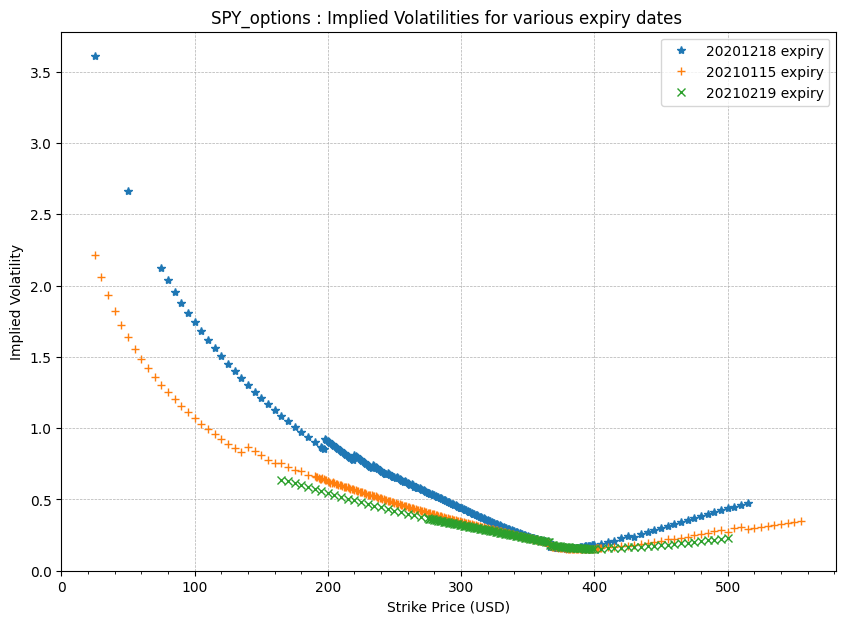

In [9]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f0, ax0 = plt.subplots(1)
f0.set_figheight(7)
f0.set_figwidth(10)
ax0.plot(summary_df['strike'],summary_df['impliedvol17'],'*',label = '20201218 expiry')
ax0.plot(summary_df['strike'],summary_df['impliedvol45'],'+',label = '20210115 expiry')
ax0.plot(summary_df['strike'],summary_df['impliedvol80'],'x',label = '20210219 expiry')
ax0.xaxis.set_major_locator(ticker.AutoLocator())
ax0.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax0.grid(linestyle = '--', linewidth = 0.5)
ax0.set_ylim(ymin=0)
ax0.set_xlim(xmin=0)
ax0.legend()
ax0.set_title(f'{filename} : Implied Volatilities for various expiry dates ')
ax0.set_xlabel('Strike Price (USD)')
ax0.set_ylabel('Implied Volatility')
plt.show(f0)
f0.savefig(f'{filename}_vol_all.jpeg')

In [10]:
#get atm implied vols, this is an approximation but good enough
atm_vols = []
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    print(adjusted_summary_df)
    atm_vols.append(np.interp(S,adjusted_summary_df.iloc[:, 0],adjusted_summary_df.iloc[:, 1]))
#atm_vols

     strike  impliedvol17
0      25.0      3.606730
1      50.0      2.660929
2      75.0      2.120640
3      80.0      2.035340
4      85.0      1.955363
..      ...           ...
250   495.0      0.424099
251   500.0      0.437003
252   505.0      0.449745
253   510.0      0.462328
254   515.0      0.474756

[255 rows x 2 columns]
     strike  impliedvol45
0      25.0      2.216993
1      50.0      1.635664
2      75.0      1.303580
3      80.0      1.251152
4      85.0      1.201995
..      ...           ...
274   535.0      0.321311
275   540.0      0.328513
276   545.0      0.335634
277   550.0      0.342676
278   555.0      0.349640

[278 rows x 2 columns]
     strike  impliedvol80
20    165.0      0.637820
21    170.0      0.629293
22    175.0      0.613090
23    180.0      0.601947
24    185.0      0.589661
..      ...           ...
247   480.0      0.205924
248   485.0      0.216124
249   490.0      0.216147
250   495.0      0.222877
251   500.0      0.229516

[167 rows x 2 c

In [11]:
for i,days in enumerate(days_to_expiry):
    trial_beta = 0.5
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    
    #params
    sigma = atm_vols[i]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {rate} {T}')

    #marketvols
    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    marketvols = adjusted_summary_df.iloc[:,1].to_numpy()
    adjusted_summary_list = list(zip(strikes, marketvols ))

    dd_price = []
    dd_impl_vol = []

    for strike, vol in adjusted_summary_list:
        if strike > S:
            dd_price_call   = displaced_diffusion_call(F,strike,rate,sigma,T,trial_beta)
            dd_price.append(dd_price_call)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_call,T,'call'))
        else:
            dd_price_put    = displaced_diffusion_put(F,strike,rate,sigma,T,trial_beta)
            dd_price.append(dd_price_put)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_put,T,'put'))

    adjusted_summary_df['dd_price'] = dd_price
    adjusted_summary_df['dd_impl_vol'] = dd_impl_vol

    #print(adjusted_summary_df)


366.02 366.0413953221589 0.200905534391913 0.0012550044444444445 0.04657534246575343
366.02 366.11256803322914 0.1972176434869465 0.0020510755555555554 0.1232876712328767
366.02 366.1970384412155 0.2002402677797878 0.0022062799999999997 0.2191780821917808


In [12]:
def dd_calibration(S,strikes,rate,sigma,T,beta, market_vols):
    err = 0.0 
    adjusted_summary_list = list(zip(strikes, market_vols ))
    for strike, vol in adjusted_summary_list:
        if strike > S:
            dd_price_call   = displaced_diffusion_call(F,strike,rate,sigma,T,beta[0])
            imp_vol  = implied_volatility(S,strike,rate,dd_price_call,T,'call')
        else:
            dd_price_put    = displaced_diffusion_put(F,strike,rate,sigma,T,beta[0])
            imp_vol  = implied_volatility(S,strike,rate,dd_price_put,T,'put')
        err += (vol - imp_vol) ** 2
    return err

In [13]:
sigma_beta_pair = []
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    
    #params
    sigma = atm_vols[i]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {rate} {T}')

    strikes = adjusted_summary_df.iloc[:,0].to_numpy()
    market_vols = adjusted_summary_df.iloc[:,1].to_numpy()

    initial = [0.5]
    result = least_squares(lambda x: dd_calibration(S,strikes,rate,sigma,T,x,market_vols) , initial, bounds=(0,1))
    beta = result.x[0]
    sigma_beta_pair.append([sigma,beta])
    print(f'sigma = {sigma} ;  beta ={beta}')
        

366.02 366.0413953221589 0.200905534391913 0.0012550044444444445 0.04657534246575343
sigma = 0.200905534391913 ;  beta =4.2891944026005736e-07
366.02 366.11256803322914 0.1972176434869465 0.0020510755555555554 0.1232876712328767
sigma = 0.1972176434869465 ;  beta =3.461949530851995e-07
366.02 366.1970384412155 0.2002402677797878 0.0022062799999999997 0.2191780821917808
sigma = 0.2002402677797878 ;  beta =3.8610726194293874e-12


In [14]:
#get prices for given beta
sigma_beta_pair

[[0.200905534391913, 4.2891944026005736e-07],
 [0.1972176434869465, 3.461949530851995e-07],
 [0.2002402677797878, 3.8610726194293874e-12]]

In [15]:
#displaced_diffusion_call(3662.664084743022 ,3600.0 ,0.0012550044444444445 ,0.17448532472572187,0.04657534246575343,1.3163138355318966e-06)
#displaced_diffusion_put(3662.664084743022 ,3600.0 ,0.0012550044444444445 ,0.17448532472572187,0.04657534246575343,1.3163138355318966e-06)

In [16]:
dd_summary_df = pd.DataFrame({'strike': df['strike'].unique() })
#dd_summary_df

In [17]:
for i,days in enumerate(days_to_expiry):
    adjusted_summary_df = summary_df.iloc[:, [0,1+i]].copy()
    adjusted_summary_df.dropna(inplace=True)
    #params
    sigma = sigma_beta_pair[i][0]
    beta = sigma_beta_pair[i][1]
    rate = rate_interpolate(days)/100.0
    T = days/365.0
    F = S * np.exp(rate*T)
    print(f'{S} {F} {sigma} {beta} {rate} {T}')
    strikes = adjusted_summary_df.iloc[:,0].to_numpy()

    dd_price = []
    dd_impl_vol = []

    for strike in strikes :
        if strike > S :
            dd_price_call   = displaced_diffusion_call(F,strike,rate,sigma,T,beta)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_call,T,'call'))
        else:
            dd_price_put    = displaced_diffusion_put(F,strike,rate,sigma,T,beta)
            dd_impl_vol.append(implied_volatility(S,strike,rate,dd_price_put,T,'put'))

    mykey = 'dd_impliedvol' + str(days)
    day_dd_imp_df = pd.DataFrame({'strike': strikes, mykey : dd_impl_vol})

    dd_summary_df = pd.merge(dd_summary_df, day_dd_imp_df, how="outer", on='strike')
    

366.02 366.0413953221589 0.200905534391913 4.2891944026005736e-07 0.0012550044444444445 0.04657534246575343
366.02 366.11256803322914 0.1972176434869465 3.461949530851995e-07 0.0020510755555555554 0.1232876712328767
366.02 366.1970384412155 0.2002402677797878 3.8610726194293874e-12 0.0022062799999999997 0.2191780821917808


In [18]:
dd_summary_df

,strike,dd_impliedvol17,dd_impliedvol45,dd_impliedvol80
0,25.0,0.579087,0.569034,NaN
1,50.0,0.463409,0.455218,NaN
2,75.0,0.400682,0.393542,NaN
3,80.0,0.391083,0.384106,NaN
4,85.0,0.382168,0.375343,NaN
...,...,...,...,...
274,535.0,NaN,0.162194,NaN
275,540.0,NaN,0.161393,NaN
276,545.0,NaN,0.160602,NaN
277,550.0,NaN,0.159822,NaN


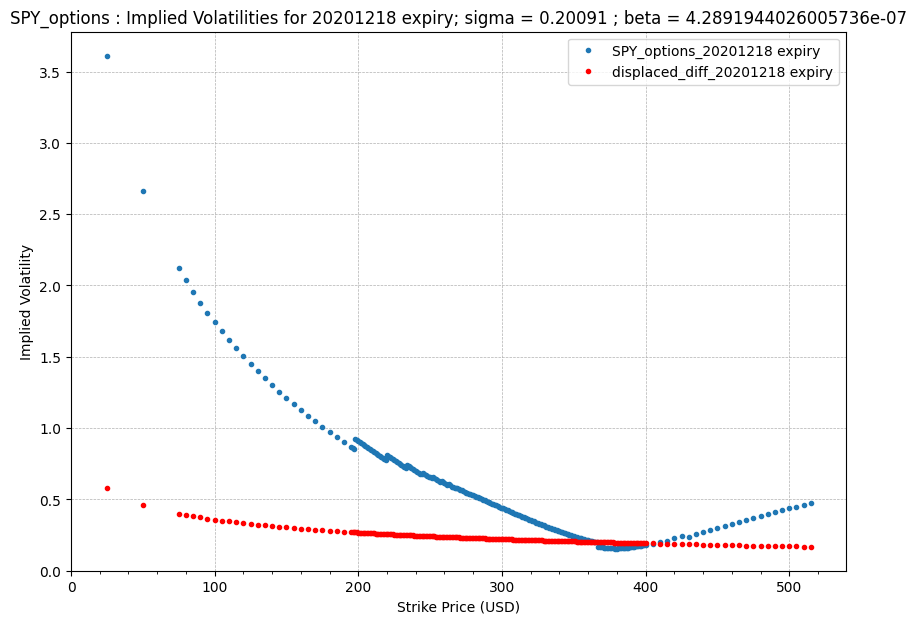

In [19]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f1, ax1 = plt.subplots(1)
f1.set_figheight(7)
f1.set_figwidth(10)
ax1.plot(summary_df['strike'],summary_df['impliedvol17'],'.',label = f'{filename}_20201218 expiry')
ax1.plot(summary_df['strike'],dd_summary_df['dd_impliedvol17'],'.',color='red',label = 'displaced_diff_20201218 expiry')
ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.grid(linestyle = '--', linewidth = 0.5)
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.legend()
ax1.set_title(f'{filename} : Implied Volatilities for 20201218 expiry; sigma = {sigma_beta_pair[0][0]:.5f} ; beta = {sigma_beta_pair[0][1]}')
ax1.set_xlabel('Strike Price (USD)')
ax1.set_ylabel('Implied Volatility')
plt.show(f1)
f1.savefig(f'{filename}_20201218_expiry_vol.jpg')

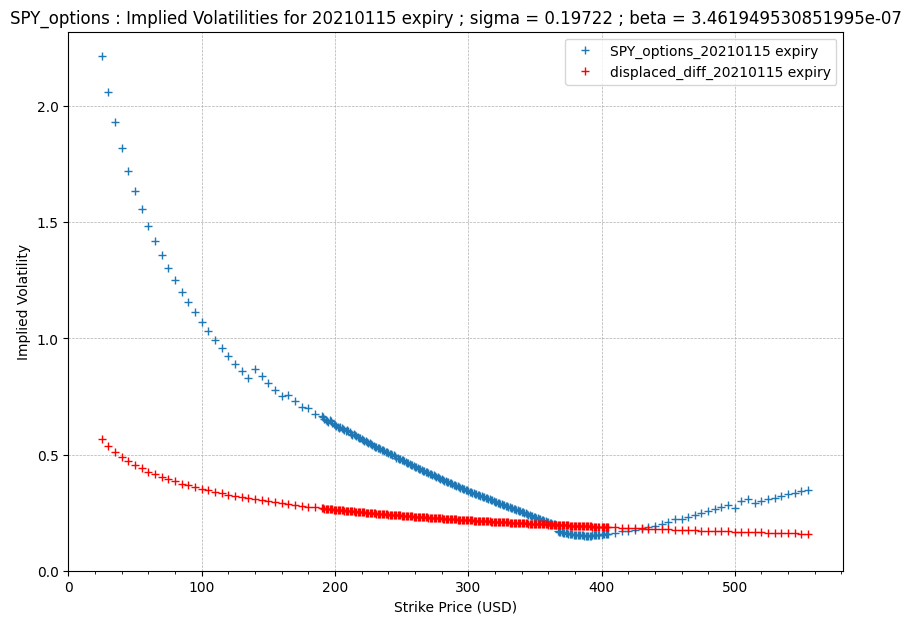

In [20]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f2, ax2 = plt.subplots(1)
f2.set_figheight(7)
f2.set_figwidth(10)
ax2.plot(summary_df['strike'],summary_df['impliedvol45'],'+',label = f'{filename}_20210115 expiry')
ax2.plot(summary_df['strike'],dd_summary_df['dd_impliedvol45'],'+',color='red',label = 'displaced_diff_20210115 expiry')
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.grid(linestyle = '--', linewidth = 0.5)
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)
ax2.legend()
ax2.set_title(f'{filename} : Implied Volatilities for 20210115 expiry ; sigma = {sigma_beta_pair[1][0]:.5f} ; beta = {sigma_beta_pair[1][1]}')
ax2.set_xlabel('Strike Price (USD)')
ax2.set_ylabel('Implied Volatility')
plt.show(f2)
f2.savefig(f'{filename}_20210115_expiry_vol.jpg')

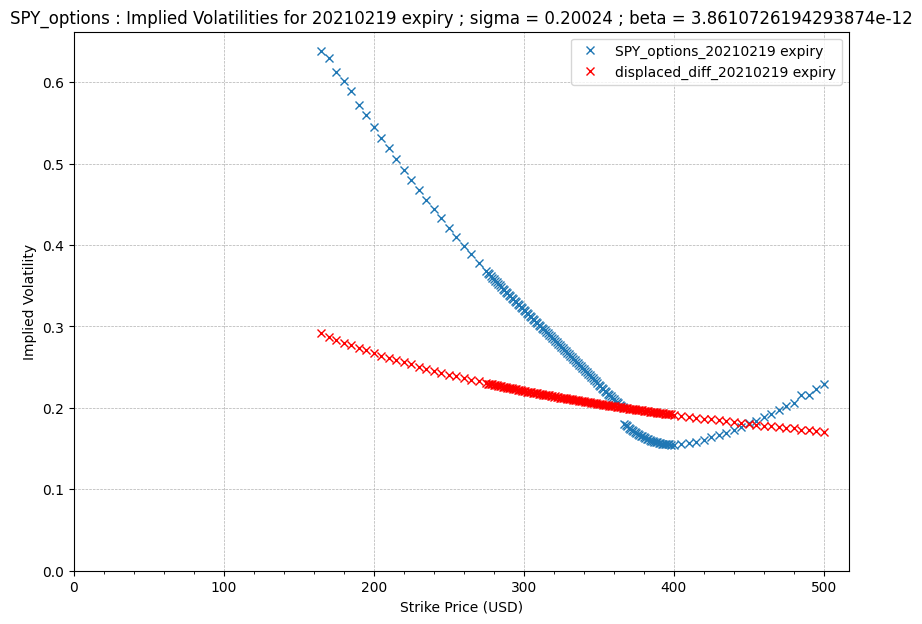

In [21]:
#pd.set_option('display.max_rows', 500) 
import matplotlib.ticker as ticker  
f3, ax3 = plt.subplots(1)
f3.set_figheight(7)
f3.set_figwidth(10)
ax3.plot(summary_df['strike'],summary_df['impliedvol80'],'x',label = f'{filename}_20210219 expiry')
ax3.plot(summary_df['strike'],dd_summary_df['dd_impliedvol80'],'x',color='red',label = 'displaced_diff_20210219 expiry')
ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.grid(linestyle = '--', linewidth = 0.5)
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.legend()
ax3.set_title(f'{filename} : Implied Volatilities for 20210219 expiry ; sigma = {sigma_beta_pair[2][0]:.5f} ; beta = {sigma_beta_pair[2][1]}')
ax3.set_xlabel('Strike Price (USD)')
ax3.set_ylabel('Implied Volatility')
plt.show(f3)
f3.savefig(f'{filename}_20210119_expiry_vol.jpg')